In [101]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic

## 1. Gather Data ##
#### This a sample credit card transactions dataset obtained from Ahmed M., the goal is to predict the anomalies in the dataset and potential use the data to train a model for detecting anomalies

In [104]:
df = pd.read_csv("data/credit_card_transactions.csv")

## 2. Assess Data
Assess the dataset for quality and tidiness issues

In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             5000 non-null   int64  
 1   trans_date_trans_time  5000 non-null   object 
 2   cc_num                 5000 non-null   int64  
 3   merchant               5000 non-null   object 
 4   category               5000 non-null   object 
 5   amt                    5000 non-null   float64
 6   first                  5000 non-null   object 
 7   last                   5000 non-null   object 
 8   gender                 5000 non-null   object 
 9   street                 5000 non-null   object 
 10  city                   5000 non-null   object 
 11  state                  5000 non-null   object 
 12  zip                    5000 non-null   int64  
 13  lat                    5000 non-null   float64
 14  long                   5000 non-null   float64
 15  city

In [109]:
df.shape

(5000, 24)

#### 2.1 Key Observations: ####
- Target Column: is_fraud is likely ground truth for fraud detection (binary: 0 for normal, 1 for fraud).
- Mixed Data Types: Includes numerical, categorical, and geospatial data.
- Incomplete Data: merch_zipcode has missing values.
- Temporal Component: trans_date_trans_time and unix_time represent time-based data.
- Geospatial Features: Latitude/longitude of transactions and merchants (lat, long, merch_lat, merch_long).

#### 2.2 Potential Anomalies: ####
- Unusually large transactions (amt).
- Geographical mismatches (e.g., large distance between lat/long and merch_lat/merch_long)
- Suspicious temporal patterns (e.g., multiple transactions in short bursts).
- Rare categories or merchants.

In [112]:
df.head(5)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,28705.0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,NaN
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,83236.0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,NaN
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,22844.0


## Clean Data/Pre-Processing

In [115]:
# Make copy of data before cleaning
df_cleaned = df.copy()

### 3.1 merch_zipcode has missing values and is float

In [118]:
df.merch_zipcode.value_counts()

merch_zipcode
43436.0    5
95637.0    4
21773.0    4
6615.0     4
10541.0    4
          ..
82327.0    1
76834.0    1
65247.0    1
13343.0    1
13036.0    1
Name: count, Length: 3729, dtype: int64

In [120]:
## calculate distance between lat/long and merch_lat/merch_long

df_cleaned['distance'] = df_cleaned.apply(
    lambda x: geodesic((x['lat'], x['long']), (x['merch_lat'], x['merch_long'])).miles, axis=1
)


### 4. Exploring Data/Analysis

In [153]:
#Using Isolation Forest to generate anomaly score 
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Select features
numerical_features = ['amt', 'distance', 'city_pop']
categorical_features = ['category', 'gender']

# Encode categorical features
encoder = OneHotEncoder()
encoded_categorical = encoder.fit_transform(df_cleaned[categorical_features]).toarray()

# Scale numerical features
scaler = StandardScaler()
scaled_numerical = scaler.fit_transform(df_cleaned[numerical_features])

# Combine features
combined_features = np.hstack([scaled_numerical, encoded_categorical])

# Fit Isolation Forest
model = IsolationForest(contamination=0.05, random_state=42)
df_cleaned['anomaly_score'] = model.fit_predict(combined_features)

df_cleaned['predicted_fraud'] = (df_cleaned['anomaly_score'] == -1 ).astype(int)

In [157]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Ground truth and predictions
y_true = df_cleaned['is_fraud']  # Ground truth
y_pred = df_cleaned['predicted_fraud']  # Detected anomalies

# Calculate metrics
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Print results
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


Precision: 0.06
Recall: 0.64
F1-Score: 0.10
Confusion Matrix:
[[4742  236]
 [   8   14]]


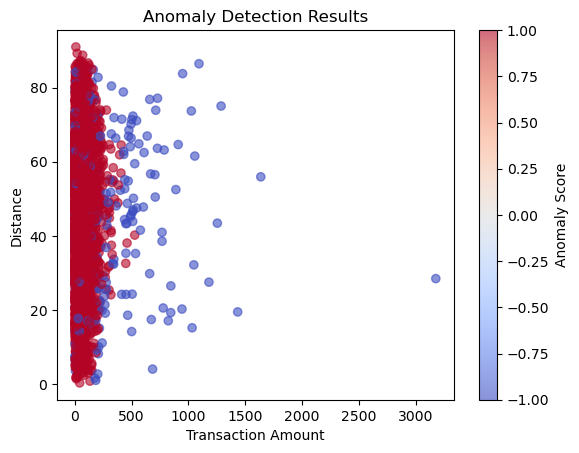

In [155]:
import matplotlib.pyplot as plt

plt.scatter(df_cleaned['amt'], df_cleaned['distance'], c=df_cleaned['anomaly_score'], cmap='coolwarm', alpha=0.6)
plt.xlabel('Transaction Amount')
plt.ylabel('Distance')
plt.title('Anomaly Detection Results')
plt.colorbar(label='Anomaly Score')
plt.show()
